# [NTDS'18] milestone 4: graph signal processing
[ntds'18]: https://github.com/mdeff/ntds_2018

[Rodrigo Pena](https://people.epfl.ch/254838), [EPFL LTS2](http://lts2.epfl.ch)

## Students

* Team: `30`
* Students: `Joachim Tapparel, Tim Tuuva, Lucas Biotto, Anael Buchegger`
* Dataset: `Free Music Archive`

## Rules

* Milestones have to be completed by teams. No collaboration between teams is allowed.
* Textual answers shall be short. Typically one to two sentences.
* Code has to be clean.
* You cannot import any other library than we imported.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart & Run All" in Jupyter.

## Objective

The goal of this milestone is to do some Graph Signal Processing (GSP) on the data of your project.

### A note about plotting

There are several questions in this milestone that ask you to plot a signal on your network.
There are several ways from which you could approach it.
In all cases, compute the position of the nodes a single time at the beginning, as this is likely to be a costly operation.
Using a single layout for all the graph plots will also make it easier to compare the plots.
Indeed, the only thing changing between plots is the signal displayed.
You can represent the features/labels lying on the graph via node **colors**.
To do so, make sure to have a consistent color map throughout and remember to display a colorbar and scale in all plots, so that we can tell what numbers the colors represent.

* An option is to use the **Laplacian eigenmaps** that you have seen in the previous milestone to embed your graph on the plane. For example:
  ```
  from matplotlib import pyplot as plt
  plt.scatter(eigenvectors[:, 1], eigenvectors[:, 2], c=signal, alpha=0.5)
  plt.colorbar()
  ```
* Another option is to use the plotting capabilities of **[NetworkX](https://networkx.github.io)**.
  See the documentation of its [drawing methods](https://networkx.github.io/documentation/stable/reference/drawing.html).
  For example:
  ```
  import networkx as nx
  graph = nx.from_scipy_sparse_matrix(adjacency)
  coords = nx.spring_layout(graph)  # Force-directed layout.
  coords = eigenvectors[:, 1:3]  # Laplacian eigenmaps.
  nx.draw_networkx_nodes(graph, coords, node_size=60, node_color=signal)
  nx.draw_networkx_edges(graph, coords, alpha=0.3)
  ```
* Another option is to use the plotting capabilities of the **[PyGSP](https://github.com/epfl-lts2/pygsp)**, a Python package for Graph Signal Processing.
  **Note that your are forbidden to use the PyGSP for anything else than plotting.**
  See the documentation of its [plotting utilities](https://pygsp.readthedocs.io/en/stable/reference/plotting.html).
  For example:
  ```
  import pygsp as pg
  graph = pg.graphs.Graph(adjacency)
  graph.set_coordinates('spring')  # Force-directed layout.
  graph.set_coordinates(eigenvectors[:, 1:3])  # Laplacian eigenmaps.
  graph.plot_signal(signal)
  ```
* Yet another option is to save your graph on disk, use **[Gephi](https://gephi.org)** externally, to visualize the graph, save the graph with the Gephi coordinates and finally load the nodes coordinates back into the notebook.

We encourage you to try all the above methods before making your choice. Then be consistent and use only one throughout the milestone.
NetworkX and PyGSP should already be installed in your environement. If that's not the case, install with `conda install networkx pygsp` (after activating the `ntds_2018` environment).

## 0 - Load your network

In [1]:
%matplotlib inline

If you get a `No module named 'pyunlocbox'` error when running the below cell, install the [pyunlocbox](https://github.com/epfl-lts2/pyunlocbox) with `conda install pyunlocbox` (after activating the `ntds_2018` environment).

In [103]:
import numpy as np
from scipy import sparse
import scipy.sparse.linalg
from matplotlib import pyplot as plt
from pyunlocbox import functions, solvers

# TODO
from mpl_toolkits.mplot3d import Axes3D
seaborn.set_style(style='white')

For this milestone, all we will need is a set of features/labels for each of the nodes on the network, as well as the Laplacian, $L,$ and Gradient, $\nabla_G,$ matrices that you have computed for your network while working on milestone 3.

Import those objects in the cell below (or recompute the Laplacian and Gradient from your stored adjacency matrix, if you wish).

_Note_: If your features/labels are not floating-point numbers, please convert them. For example, if your data has labels "cat" and "dog" for nodes that represent cats or dogs, respectively, you may assign the number `1.0` for the label "cat" and the number `-1.0` for the label "dog".  

In [3]:
# laplacian = np.load('../data/fma_metadata/laplacian_cos_95.npy')
adjacency = np.load('../data/fma_metadata/adjacency.npy')

# We don't want to have any isolated node so we need to remove them!
# Remove line full of 0
adjacency = adjacency[~np.all(adjacency == 0, axis=1)]

# Remove column full of 0
adjacency = adjacency.T[~np.all(adjacency.T == 0, axis=1)]

# create Laplacian
D = np.diag(sum(adjacency)) #We put the degrees on the diagonal of a matrix full of zeros, this creates the matrix D. 

#We compute the inverse of the D matrix and then put it to the square in order to have 
#D^(-1/2) for the normalisation of the Laplacian
Dinv = np.linalg.inv(D)
Dinvsquare = Dinv**(1/2)

#We just create the combinatorial and the normalized Laplacian following the lecture given in class
laplacian = D-adjacency
laplacian_norm = Dinvsquare@laplacian@Dinvsquare


n_nodes = int(len(laplacian))
labels = np.concatenate((np.ones(int(n_nodes/2)), -np.ones(int(n_nodes/2))));

#calculate gradient from adjacency
n_edge=(sum(sum(np.ceil(adjacency))))/2
data=[]
row_ind=[]
col_ind=[]
col_cnt=0;
for i in range(n_nodes):
    for j in range(i,n_nodes):       
         if(adjacency[i,j]): 
            data.append(np.sqrt(adjacency[i,j]));
            row_ind.append(i);
            col_ind.append(col_cnt)
            #to maintain the relation between gradient and laplacian for our undirected graph
            #we have to define an arbitrary direction for all edge
            data.append(-np.sqrt(adjacency[i,j]));           
            row_ind.append(j);
            col_ind.append(col_cnt)
            col_cnt+=1; 
    
Incidence_coo = sparse.coo_matrix((data, (row_ind, col_ind)))
gradient = Dinvsquare@Incidence_coo
gradient = gradient.T
#verify the relation netween gradient and laplacian
np.testing.assert_allclose((gradient.T @ gradient), laplacian_norm)

## 1 - Graph Fourier Transform

In this section we will observe how your feature/label vector looks like in the "Graph Fourier" domain.

### Question 1

Compute the Fourier basis vectors and the Laplacian eigenvalues. Make sure to order those from smaller to larger, $\lambda_0 \leq \lambda_1 \leq \dots \leq \lambda_{N-1},$ and use the same ordering for the Fourier basis vectors.

In [4]:
e, v = np.linalg.eigh(laplacian_norm) # Ordered Laplacian eigenvalues.
U = v                                 # Ordered graph Fourier basis.

Plot the first 3 and the last Fourier basis vectors as signals on your graph. Clearly indicate which plot belongs to which basis vector.

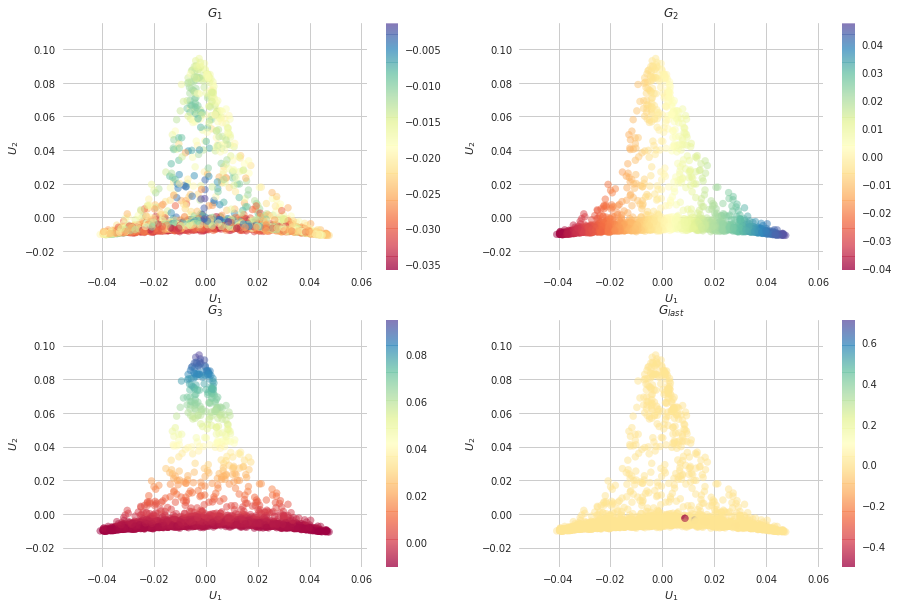

In [97]:
# Plot test:
from matplotlib import pyplot as plt
import seaborn
plt.style.use('seaborn')#switch to seaborn style
seaborn.set_style(style='whitegrid')

fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(15, 10)

#
im = axes[0,0].scatter(U[:, 1], U[:, 2], c=U[:,0], alpha=0.5, cmap='Spectral')
axes[0,0].set_xlabel('$U_1$')
axes[0,0].set_ylabel('$U_2$')
axes[0,0].set_title('$G_1$')
fig.colorbar(im, ax=axes[0,0])


im = axes[0,1].scatter(U[:, 1], U[:, 2], c=U[:,1], alpha=0.5, cmap='Spectral')
axes[0,1].set_xlabel('$U_1$')
axes[0,1].set_ylabel('$U_2$')
axes[0,1].set_title('$G_2$')
fig.colorbar(im, ax=axes[0,1])


im = axes[1,0].scatter(U[:, 1], U[:, 2], c=U[:,2], alpha=0.5, cmap='Spectral')
axes[1,0].set_xlabel('$U_1$')
axes[1,0].set_ylabel('$U_2$')
axes[1,0].set_title('$G_3$')
fig.colorbar(im, ax=axes[1,0])


im = axes[1,1].scatter(U[:, 1], U[:, 2], c=U[:,-1], alpha=0.5, cmap='Spectral')
axes[1,1].set_xlabel('$U_1$')
axes[1,1].set_ylabel('$U_2$')
axes[1,1].set_title('$G_{last}$')
fig.colorbar(im, ax=axes[1,1])


#
plt.show()

### Question 2

What can you observe in terms of local variations when comparing the basis vectors corresponding to the smallest eigenvalues to those corresponding to the largest eigenvalue? How would this justify the interpretation of the eigenvalues as "graph frequencies"?

**As we chose to plot using $U_1$ and $U_2$, $G_2$ and $G_3$ show us the axis values of each point.  
In terms of local variations, we see smooth variations for small eigenvalues and sharp variations for large eigenvalues.  
This similar to the Fourier Transform, the small eigenvalues correspond to low frequencies whereas large eigenvalues  correspond to high frequencies.  
We have to note that the first eigenvalue should be therefore the constant part of the Fourier Transform which isn't exactly are case.**

### Question 3

Implement a function that returns the Graph Fourier Transform (GFT) of a given vector $x \in \mathbb{R}^{N},$ with respect to your graph, and a function that computes the corresponding inverse GFT (iGFT).

In [80]:
def GFT(x):
    return U.T@x

def iGFT(x):
    return  U@x

### Question 4

Plot your feature/label vector as a signal on your graph

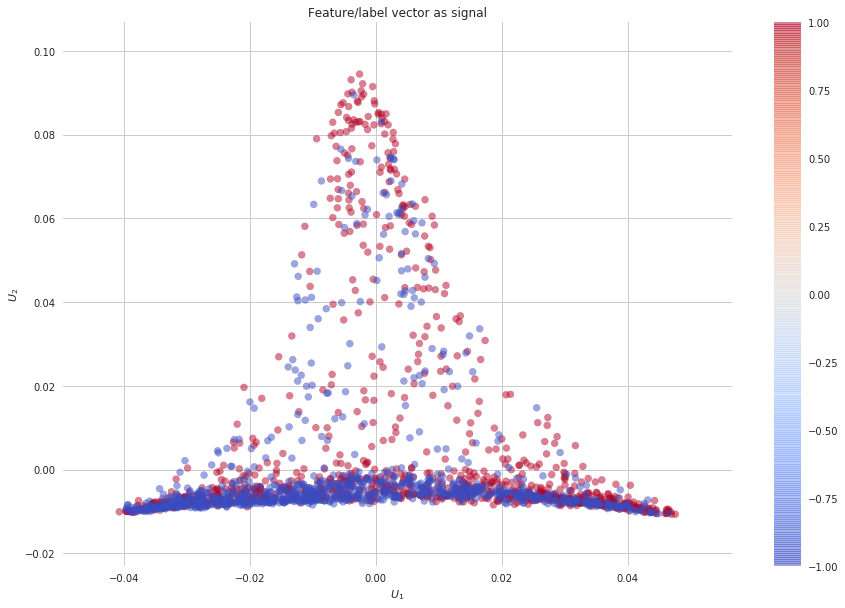

In [100]:
plt.figure(figsize=(15, 10))

plt.scatter(U[:, 1], U[:, 2], c=labels, alpha=0.5, cmap='coolwarm')
plt.title('Feature/label vector as signal')
plt.xlabel('$U_1$')
plt.ylabel('$U_2$')
plt.colorbar()
plt.show()

Plot the absolute values of the GFT of your feature/label signal as a function of the graph eigenvalues. Make sure to add a marker indicating the position of each graph eigenvalue, and remember to properly name the axes.

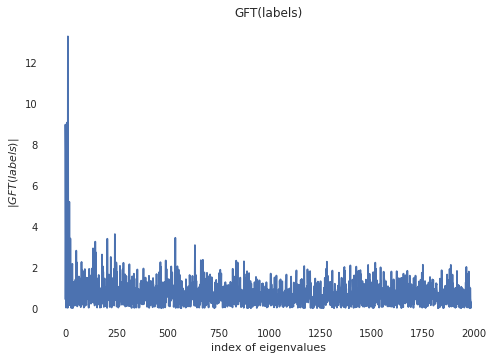

In [110]:
plt.plot(abs(GFT(labels)))
plt.xlabel('index of eigenvalues')
plt.ylabel('$|GFT(labels)|$')
plt.title('GFT(labels)')
plt.show()

### Question 5

Discuss the behavior of the GFT that you plotted in the last question via comparing the plot of your label signal and those of the Fourier basis of Question 1. Would you consider your labels a "low-pass" or "high-pass" signal, or yet something else entirely?

**Your answer here.**

## 2 - Filtering on graphs

In this section we will check how filtered Dirac impulses diffuse on your graph.

### Question 6 

Implement the following three filter kernels and the graph filtering operation.

- The **heat kernel** is supposed to take in a vector of eigenvalues `e` and a parameter `t` and output a vector of evaluations of the heat kernel at those eigenvalues (see the course slides for help).
- The **inverse filter** kernel is supposed to take in a vector of eigenvalues `e` and a parameter `t` and implement spectrally the  filter defined in the node domain by $f_{out}  = (I + t L)^{-1} f_{in},$ where $f_{in}, f_{out} \in \mathbb{R}^{N}$ are, repectively, the input and output signals to the filter.
- The **rectangle kernel** takes in a vector of eigenvalues `e` and parameters `l_min` and `l_max` and returns `1.0` at coordinates satisfying $(e[l] \geq l_{min}) \wedge (e[l] \leq l_{max}),$ and `0.0` otherwise.
- The **graph filtering** operation takes a graph signal $x \in \mathbb{R}^{N}$, a spectral graph `kernel` and a set of keyworded variables, and returns the corresponding filtered signal.
    - _Hint:_ Remember that you have implemented the `GFT` and `iGFT` operations in Question 3.
    - The `**kwargs` is a placeholder to collect supplementary pairs of keyword-values that are not known by the implementation before execution time.
      The `kwargs` variable is a dictionary whose keyes and values are the parameter names and values.
      This is useful to allow both `graph_filter(x, heat_kernel, tau=1.0)` and `graph_filter(x, rectangle_kernel, lambda_min=0.0, lambda_max=1.0)` to be valid calls from the same implementation.
      One can then defer the keyword-value assignment to the `kernel` call: `foo = kernel(bar, **kwargs)`.

In [83]:
def heat_kernel(e, t):    
    return np.exp(-t * np.array(e) )

def inverse_kernel(e, t):
    return 1/(1+t*np.array(e))

def rectangle_kernel(e, l_min, l_max):
    return ((np.array(e)>l_min) & (np.array(e)<l_max)).astype(int)

def graph_filter(x, kernel, **kwargs):
    return iGFT(kernel(**kwargs)*GFT(x))

### Question 7

Plot all three filter kernels in the spectral domain. Remember to properly name the axes and title the plots. Choose filter parameters that best approximate the behavior of the GFT of your feature/label signal (as seen in Question 4).

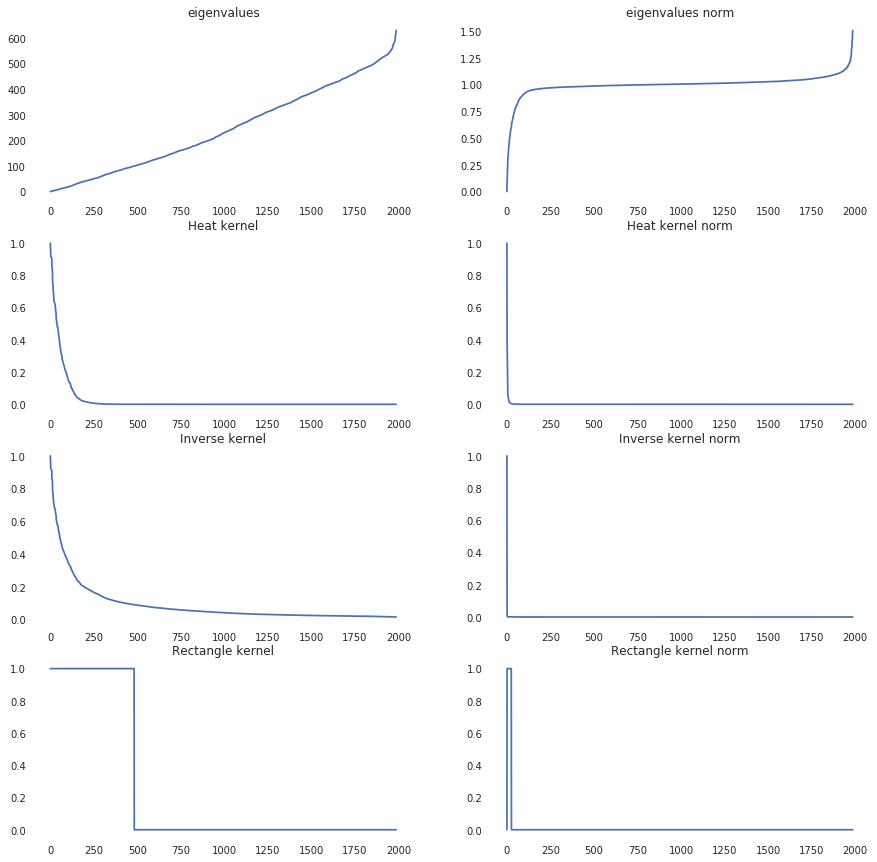

In [84]:
e_non_norm, v_non_norm = np.linalg.eigh(laplacian) # Ordered Laplacian eigenvalues.
fig=plt.figure(figsize=(15, 15));
ax1=fig.add_subplot(421)
ax1.set_title("eigenvalues")
ax1.plot(e_non_norm)
ax2=fig.add_subplot(422)
ax2.set_title("eigenvalues norm")
ax2.plot(e)
ax3=fig.add_subplot(423)
ax3.set_title("Heat kernel")
ax3.plot(heat_kernel(e_non_norm,0.1))
ax4=fig.add_subplot(424)
ax4.set_title("Heat kernel norm")
ax4.plot(heat_kernel(e,9))
ax5=fig.add_subplot(425)
ax5.set_title("Inverse kernel")
ax5.plot(inverse_kernel(e_non_norm,0.1))
ax6=fig.add_subplot(426)
ax6.set_title("Inverse kernel norm")
ax6.plot(inverse_kernel(e,1700))
ax7=fig.add_subplot(427)
ax7.set_title("Rectangle kernel")
ax7.plot(rectangle_kernel(e_non_norm,0,100));
ax8=fig.add_subplot(428)
ax8.set_title("Rectangle kernel norm")
ax8.plot(rectangle_kernel(e,0,0.6));

We choosed to use the normalized laplacian to get a better graph using the laplacian eigenmap. Because of this choice the kernel frequency response are not very readable, so we add also the graphs of the non normalized ones.  

### Question 8

Consider two Dirac impulses arbitrarily placed on your graph. Plot their filtered versions by the three filter kernels implemented in Question 6.

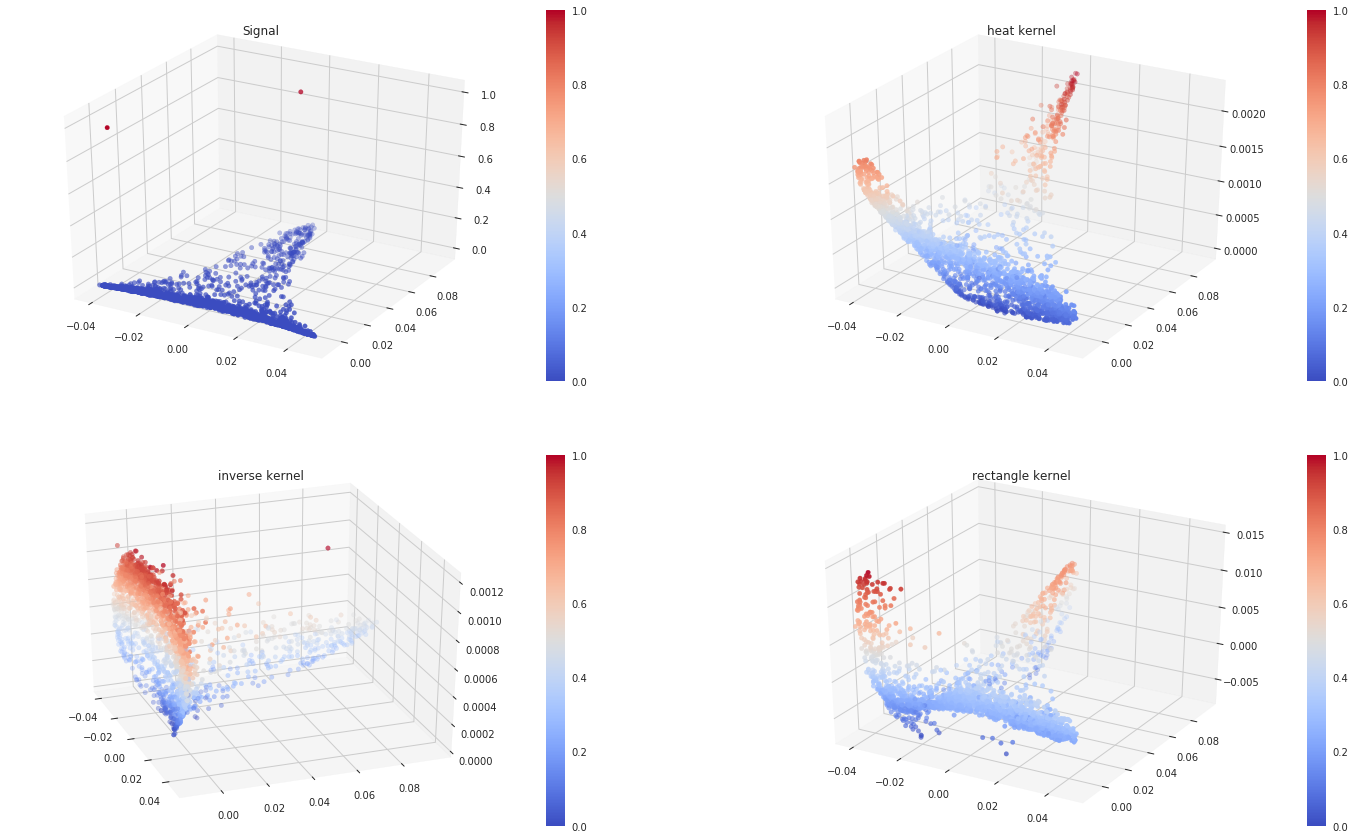

In [85]:
from mpl_toolkits.mplot3d import Axes3D

#good nodes 1044(tip) 757 (bottom left)
x=np.zeros(n_nodes)
node1=1044;#np.random.randint(n_nodes);
node2=757;#np.random.randint(n_nodes);
x[node1]=1
x[node2]=1

fig = plt.figure(figsize=(25, 15))

ax = fig.add_subplot(221, projection='3d')
ax_c=ax.scatter(coords[:,0],coords[:,1], x, c=x,cmap="coolwarm")
plt.colorbar(ax_c)
fig.colorbar
ax.set_title("Signal")

graph_heat=graph_filter(x,heat_kernel,e=e,t=9)

ax1 = fig.add_subplot(222, projection='3d')
ax1.scatter(coords[:,0],coords[:,1], graph_heat, c=graph_heat,cmap="coolwarm")
ax1.set_title("heat kernel")
plt.colorbar(ax_c)
graph_inverse=graph_filter(x,inverse_kernel,e=e,t=1700)
ax2 = fig.add_subplot(223, projection='3d')
ax2.scatter(coords[:,0],coords[:,1], graph_inverse, c=graph_inverse,cmap="coolwarm")
ax2.set_title("inverse kernel")
ax2.view_init(30,-20)
plt.colorbar(ax_c)
graph_rect=graph_filter(x,rectangle_kernel,e=e,l_min=0,l_max=0.6)
ax3 = fig.add_subplot(224, projection='3d')
ax3.scatter(coords[:,0],coords[:,1], graph_rect, c=graph_rect,cmap="coolwarm")
ax3.set_title("rectangle kernel");
plt.colorbar(ax_c);


Comment on the "diffusion" of the Diracs induced by the filters. What does it say about the "communication" of information across your network? Relate that to the network connectivity measures that you analyzed during the previous milestones.

**Our graph has around 250'000 edges which correspond to around 12% of the maximal number of edges. Because of this high number of links and their very homogeneous repartition between the nodes, the diffusion of two filtred dirac impulses propagate to a high number of adjacent nodes, which leads to either very little propagation or a large diffusion in almost all the nodes by varying the `t` parameter a little bit**

## 3 - De-noising

In this section we will add some centered Gaussian noise to your feature/label signal and attempt to recover it.

### Question 9

In the cell below, set the noise variance $\sigma^2$ by making sure that the signal-to-noise ratio $SNR = \frac{\operatorname{Var}(\text{labels})}{\sigma^2}$ is about  $1.5$.

_Note:_ Actually, you might want to play with the noise variance here and set it to different values and see how the denoising filters behave.

In [14]:
noise_variance = np.var(labels) / 1.5
noisy_measurements = labels + noise_variance * np.random.randn(n_nodes)

### Question 10

In the denoising setting, a common graph signal processing assumption is that the signal $z$ that we want to recover is "smooth", in the sense that $\|\nabla_G z\|_2 = \sqrt{z^{\top} L z}$ is small, while remaining "close" to the measurements that we start with. This leads to denoising by solving the following optimization problem:

$$
z^\star = \text{arg} \, \underset{z \in \mathbb{R}^{N}}{\min} \, \|z - y\|_2^2 + \gamma z^{\top} L z, 
$$

where $y \in \mathbb{R}^{N}$ is the vector of noisy measurements.

Derive the close form solution to this problem giving $z^\star$ as a function of $y$, $\gamma$ and $L$. Does this solution correspond to any graph filtering operation that you know?

Let's derive with respect to $\mathbf{x}$:
$$
z^\star = \text{arg} \, \underset{z \in \mathbb{R}^{N}}{\min} \, \|z - y\|_2^2 + \gamma z^{\top} L z, 
$$

$$
\begin{align}
&\Rightarrow 2({z} - {y}) + 2\gamma{L}{z} = 0 \\
&\Rightarrow z+ \gamma{L}{z} = y \\
&\Rightarrow (I+ \gamma{L}){z} = y \\
\end{align}
$$

And we finally have the solution:
$$
{z^\star} = (I+ \gamma{L})^{-1} y \\
$$

The solution corresponds to a low-pass filter which is actually the inverse filter as seen previously.

### Question 11

Now, denoise the noisy measurements by passing them through the filters that you implemented in Question 6. Choose the filter parameters based on the behavior of the GFT of your original label signal (this is the prior knowledge that you input to the problem).

In [15]:
z_heat_denoised = graph_filter(noisy_measurements, heat_kernel, e=e, t=2)
z_inv_denoised = graph_filter(noisy_measurements, inverse_kernel, e=e, t=2)
z_rect_denoised = graph_filter(noisy_measurements, rectangle_kernel, e=e, l_min=0.5, l_max=1)

Plot, on your graph, the original label signal, the noisy measurements, and the three denoised version obtained above. Report on each plot the value of the corresponding relative error 
$$
\text{rel-err} = \frac{\|\text{labels} - z \|_2}{\|\text{labels}\|_2},
$$
where $z$ is the plotted signal.

In [16]:
def rel_err(labels, z):
    return np.linalg.norm(labels-z, 2) / np.linalg.norm(labels, 2)

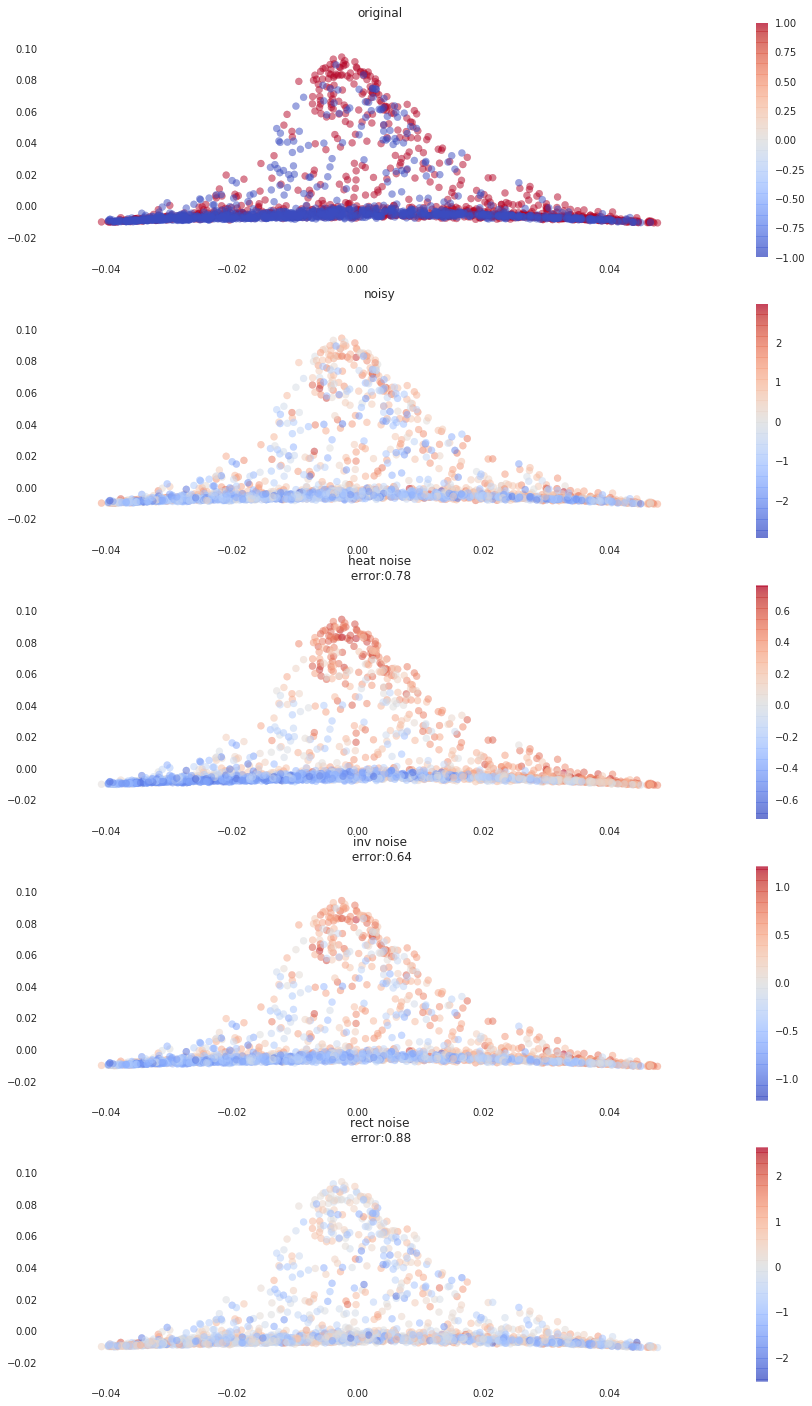

In [69]:
fig, axes = plt.subplots(nrows=5, ncols=1)
fig.set_size_inches(15, 25)

#
im = axes[0].scatter(U[:, 1], U[:, 2], c=labels, alpha=0.5, cmap='coolwarm')
axes[0].set_title('original')
plt.colorbar(im, ax=axes[0])

im = axes[1].scatter(U[:, 1], U[:, 2], c=noisy_measurements, alpha=0.5, cmap='coolwarm')
axes[1].set_title('noisy')
plt.colorbar(im, ax=axes[1])

im = axes[2].scatter(U[:, 1], U[:, 2], c=z_heat_denoised, alpha=0.5, cmap='coolwarm')
axes[2].set_title('heat noise\n error:%.2f' %rel_err(labels, z_heat_denoised))
plt.colorbar(im, ax=axes[2])

im = axes[3].scatter(U[:, 1], U[:, 2], c=z_inv_denoised, alpha=0.5, cmap='coolwarm')
axes[3].set_title('inv noise\n error:%.2f' %rel_err(labels, z_inv_denoised))
plt.colorbar(im, ax=axes[3])

im = axes[4].scatter(U[:, 1], U[:, 2], c=z_rect_denoised, alpha=0.5, cmap='coolwarm')
axes[4].set_title('rect noise\n error:%.2f' %rel_err(labels, z_rect_denoised))
plt.colorbar(im, ax=axes[4])
#
# TODO XLABELS AND YLABELS??
plt.show()

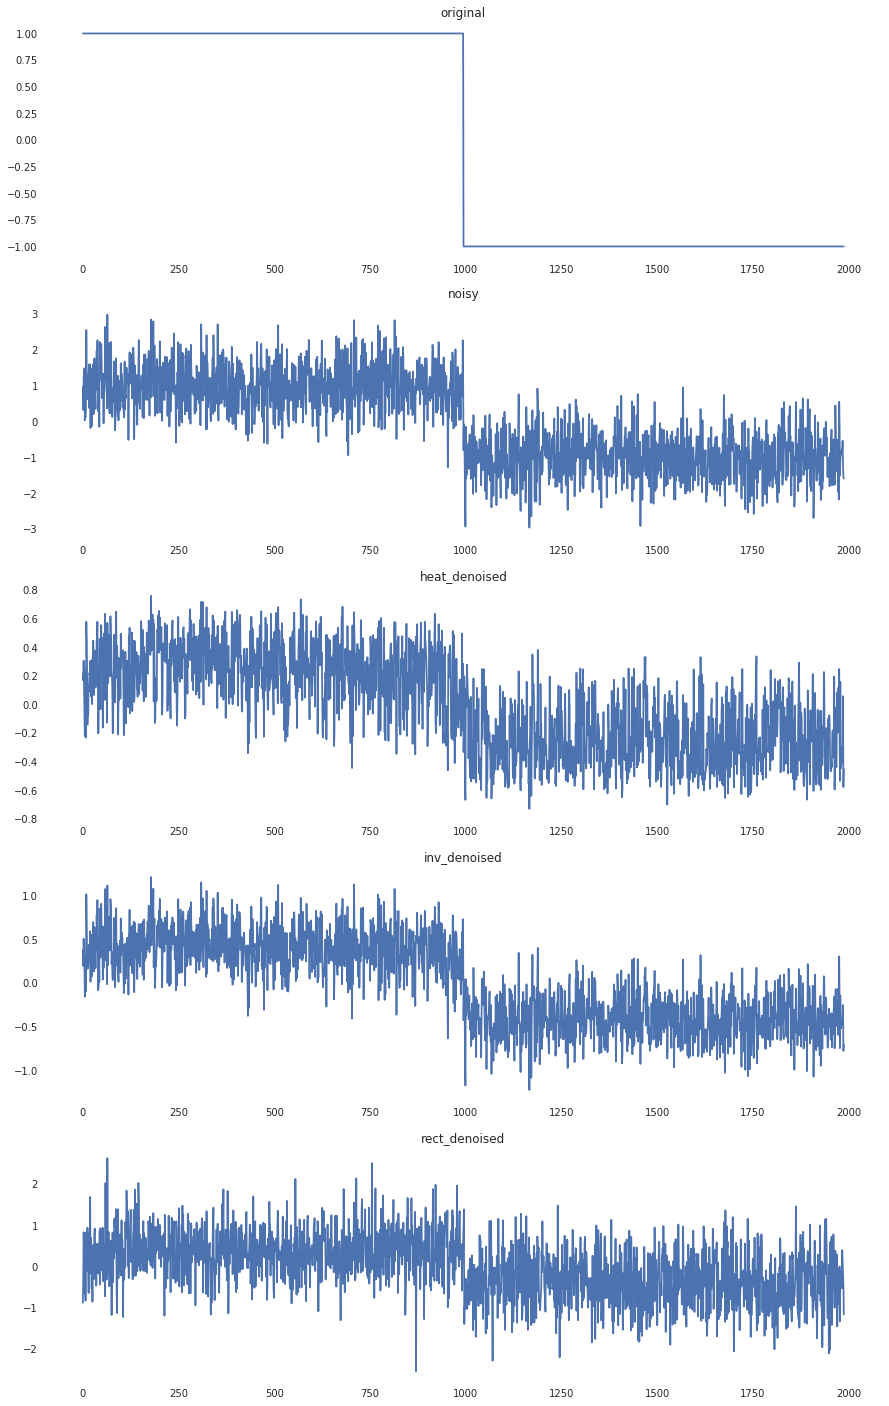

In [18]:
fig, axes = plt.subplots(nrows=5, ncols=1)
fig.set_size_inches(15, 25)

#
axes[0].plot(labels)
axes[0].set_title('original')

axes[1].plot(noisy_measurements)
axes[1].set_title('noisy')

axes[2].plot(z_heat_denoised)
axes[2].set_title('heat_denoised')

im = axes[3].plot(z_inv_denoised)
axes[3].set_title('inv_denoised')

axes[4].plot(z_rect_denoised)
axes[4].set_title('rect_denoised')

#
plt.show()

Finally, overlay on the same plot the GFT of all five signals above.

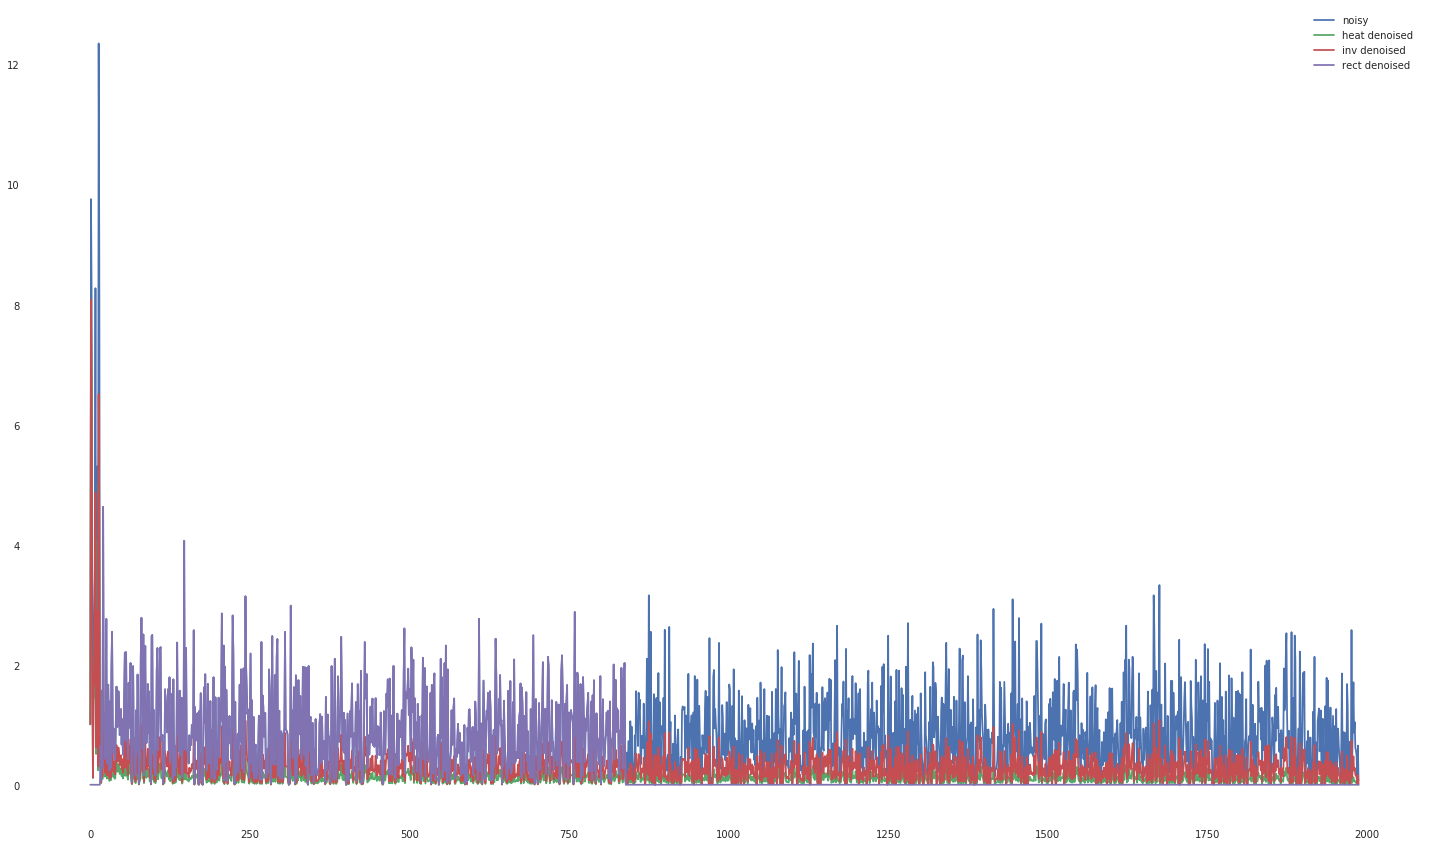

In [88]:
fig=plt.figure(figsize=(25, 15))
plt.plot(abs(GFT(noisy_measurements)), label='noisy')
plt.plot(abs(GFT(z_heat_denoised)), label='heat denoised')
plt.plot(abs(GFT(z_inv_denoised)), label='inv denoised')
plt.plot(abs(GFT(z_rect_denoised)), label='rect denoised')
plt.legend()
plt.show()

### Question 12

Comment on which denoised version seems to best match the original label signal. What is the underlying assumption behind the three filtering approaches? Do you think it holds for your label signal? Why?

**Your answer here.**

## 4 - Transductive learning

It is often the case in large networks that we can only afford to query properties/labels on a small subset of nodes. Nonetheless, if the underlying labels signal is "regular" enough, we might still be able to recover a good approximation of it by solving an offline variational problem, with constraints on the values of the measured nodes. 

In this section, we will be interested in solving such transductive learning problems by minimizing a (semi-) p-norm of the graph gradient applied to the signal of interest:

$$
\text{arg} \, \underset{z|_S = y}{\min} \|\nabla_G z\|_p^p,
$$

where $S$ is the set of measured nodes.

In English, we can say that we are looking for solutions with small "aggregated local variations", as measured by $\|\nabla_G z\|_p^p = \sum_{i=1}^{n} \sum_{j=1}^{n} \left( \sqrt{W_{ij}} |z[i] - z[j]| \right)^p,$ while satisfying the measurement constraints $z[i] = y[i]$ for $i \in S.$

We will work with two cases, according to the choices $p=1$ or $p=2.$ For $p=1,$ the problem is known as "interpolation by graph total-variation minimization," whereas for $p=2$ it is sometimes called "interpolation by Tikhonov regularization".

In order to solve these variational problems with the black-box solver provided to you, you will use the [pyunlocbox](https://pyunlocbox.readthedocs.io). This toolbox implements iterative solvers based on so-called ["proximal-splitting"](https://en.wikipedia.org/wiki/Proximal_gradient_method) methods.

### Question 13

Throughout this section, we will consider only a binarized version of your label signal. If your variable `labels` currently has values other than $\{-1, 1\},$ threshold them so that those are the only values taken in this vector. This can be done for example by choosing a number $t \in \mathbb{R}$ and then setting $\text{labels_bin}[i] = 1$ if $\text{labels}[i] \geq t$ and $\text{labels_bin}[i] = 0$ otherwise.

In [21]:
labels_bin = labels # Rock: 1 | Hip-Hop: -1

Now, subsample this binarized label signal by $70\%$ by choosing, uniformly at random, $30\%$ of the nodes whose labels we will keep.

You will do this by computing a "measurement mask" vector `w` with `1.0`'s at the measured coordinates, and $0.0$'s otherwise.

In [22]:
mn_ratio = 0.3
m = int(mn_ratio * n_nodes)  # Number of measurements.

# TODO
w = np.random.choice([0, 1], size=n_nodes, p=[1-mn_ratio, mn_ratio])
# Or
w = np.array([0] * (n_nodes - m) + [1] * m)
np.random.shuffle(w)

Plot the subsampled signal on the graph. _Hint:_ you might want to set to `numpy.nan` the values of the un-measured nodes for a cleaner plot.

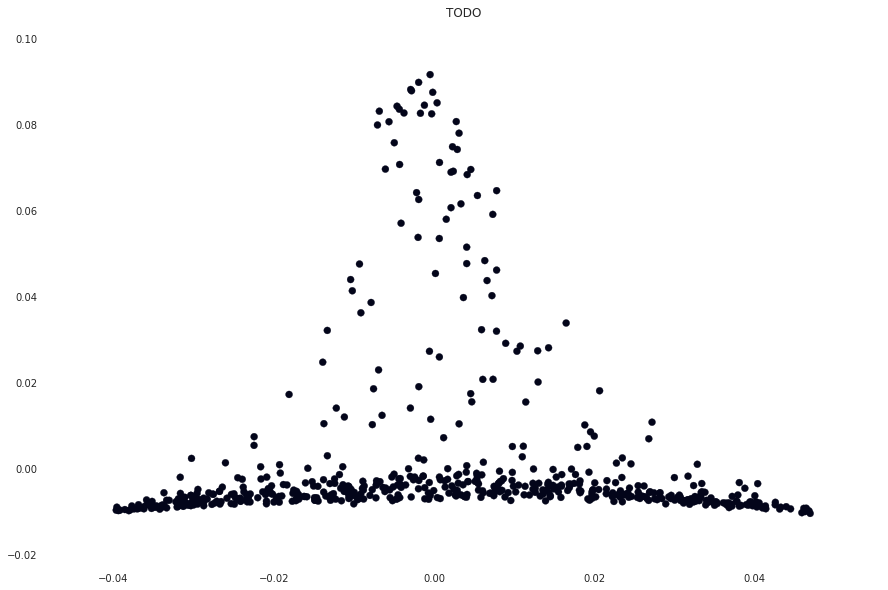

In [23]:
# Select the mask
selected = w.astype(float)
selected[selected == 0] = np.nan

# Plot
plt.figure(figsize=(15, 10))

plt.scatter(U[:, 1], U[:, 2], c=selected)
plt.title('TODO')
plt.show()

### Interlude

For the solution of the variational problems you can use the following function as a "black-box". 

You will just need to provide a `gradient` matrix (which you should already have from Section 0), and an orthogonal projection operator `P` onto the span of the measured coordinates (made precise in the next question).

In [30]:
def graph_pnorm_interpolation(gradient, P, x0=None, p=1., **kwargs):
    r"""
    Solve an interpolation problem via gradient p-norm minimization.

    A signal :math:`x` is estimated from its measurements :math:`y = A(x)` by solving
    :math:`\text{arg}\underset{z \in \mathbb{R}^n}{\min}
    \| \nabla_G z \|_p^p \text{ subject to } Az = y` 
    via a primal-dual, forward-backward-forward algorithm.

    Parameters
    ----------
    gradient : array_like
        A matrix representing the graph gradient operator
    P : callable
        Orthogonal projection operator mapping points in :math:`z \in \mathbb{R}^n` 
        onto the set satisfying :math:`A P(z) = A z`.
    x0 : array_like, optional
        Initial point of the iteration. Must be of dimension n.
        (Default is `numpy.random.randn(n)`)
    p : {1., 2.}
    kwargs :
        Additional solver parameters, such as maximum number of iterations
        (maxit), relative tolerance on the objective (rtol), and verbosity
        level (verbosity). See :func:`pyunlocbox.solvers.solve` for the full
        list of options.

    Returns
    -------
    x : array_like
        The solution to the optimization problem.

    """
    
    if(x0 == None):
        x0 = np.random.randn(n_nodes)
        x0 = np.zeros(n_nodes)

    
    grad = lambda z: gradient.dot(z)
    div = lambda z: gradient.transpose().dot(z)

    # Indicator function of the set satisfying :math:`y = A(z)`
    f = functions.func()
    f._eval = lambda z: 0
    f._prox = lambda z, gamma: P(z)

    # :math:`\ell_1` norm of the dual variable :math:`d = \nabla_G z`
    g = functions.func()
    g._eval = lambda z: np.sum(np.abs(grad(z)))
    g._prox = lambda d, gamma: functions._soft_threshold(d, gamma)

    # :math:`\ell_2` norm of the gradient (for the smooth case)
    h = functions.norm_l2(A=grad, At=div)

    stepsize = (0.9 / (1. + scipy.sparse.linalg.norm(gradient, ord='fro'))) ** p
    
    solver = solvers.mlfbf(L=grad, Lt=div, step=stepsize)

    if p == 1.:
        problem = solvers.solve([f, g, functions.dummy()], x0=x0, solver=solver, **kwargs)
        return problem['sol']
    if p == 2.:
        problem = solvers.solve([f, functions.dummy(), h], x0=x0, solver=solver, **kwargs)
        return problem['sol']
    else:
        return x0

### Question 14

During the iterations of the algorithm used for solving the variational problem, we have to make sure that the labels at the measured nodes stay the same. We will do this by means of an operator `P` which, given a vector $a \in \mathbb{R}^{N},$ returns another vector $b \in \mathbb{R}^{N}$ satisfying $b[i] = \text{labels_bin}[i]$ for every node $i$ in the set $S$ of known labels, and $b[i] = a[i]$ otherwise. Write in the cell below the function for this orthogonal projection operator `P`.

_Hint:_ remember you have already computed the mask `w`.

In [52]:
def P(a): # Not sure TODO
    b = w * labels_bin - (w-1) * a
    return b

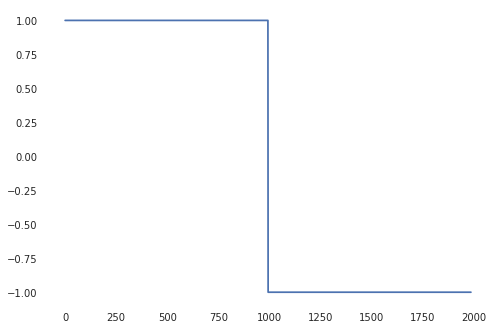

In [53]:
plt.plot(P(P(labels_bin)))

### Question 15

Solve the variational problems for $p = 1$ and $p = 2$. Record the solution for the $1-$norm minimization under `sol_1norm_min` and the one for $2-$norm minimization under `sol_2norm_min`.

Compute also binarized versions of these solutions by thresholding the values with respect to $0$, that is, non-negative values become `1.0`, while negative values become `-1.0`. Store those binarized versions under `sol_1norm_bin` and `sol_2norm_bin`, respectively.

In [54]:
#gradient = nx.incidence_matrix(nx.from_numpy_array(laplacian_norm))
sparse.csr_matrix(gradient).shape

(250493, 1988)

In [55]:
# TODO GRADIENT??
sol_1norm_min = graph_pnorm_interpolation(sparse.csr_matrix(gradient), P, p=1.)

sol_2norm_min = graph_pnorm_interpolation(sparse.csr_matrix(gradient), P, p=2.)

threshold = 0

sol_1norm_bin = np.sign(sol_1norm_min - threshold)

sol_2norm_bin = np.sign(sol_2norm_min - threshold)

Solution found after 2 iterations:
    objective function f(sol) = 7.327902e+03
    stopping criterion: RTOL
Solution found after 3 iterations:
    objective function f(sol) = 5.662800e+02
    stopping criterion: RTOL


Plot, on your graph, the original `labels_bin` signal, as well as the solutions to the variational problems (both binarized and otherwise). Indicate on each plot the value of the relative error $\text{rel-err} = \frac{\|\text{labels_bin} - z\|_2}{\|\text{labels_bin}\|_2}$, where $z$ is the signal in the corresponding plot.

0.8560942613438283


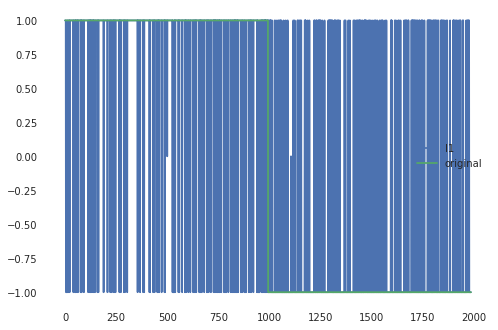

In [56]:
print(rel_err(labels, P(sol_1norm_bin)))
plt.plot(P(sol_1norm_bin), label='l1')
plt.plot(labels_bin, label='original')
plt.legend()
plt.show()

0.8593198377210932


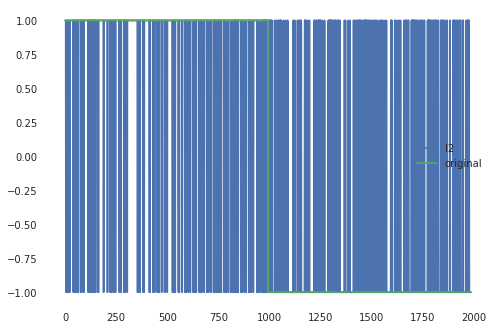

In [57]:
print(rel_err(labels, P(sol_2norm_bin)))
plt.plot(P(sol_2norm_bin), label='l2')
plt.plot(labels_bin, label='original')
plt.legend()
plt.show()

### Question 16

Now that you have got a feeling for the sort of solutions that the transductive learning problems studied can give, we will see what is the effect of the number of measurements on the accuracy of both $p-$norm minimization problems.

Towards this goal, you will write a `phase_transition()` function. This function will basically go over all the procedures that you have implemented in this section, but for varying numbers of measurements and thresholding values. It will also compute the relative error, $\text{rel-err},$ of the solutions and average them over a number of trials.

The output of the `phase_transition()` function has to be a matrix with `len(mn_ratios)` columns and `len(thresholds)` rows. Each pixel $(i,j)$ in the output matrix has to contain the average, over `n_trials` trials, of the relative error $\text{rel-err}$ in the binarized (with threshold `thresholds[i]`) solution given by `graph_pnorm_interpolation()` from observing an `mn_ratios[j]` fraction of nodes. The randomness comes from a different choice of mask `w` at each trial, hence the averaging.

The interest of this phase transition matrix is to assess what level of recovery error one could expect for a certain fraction of measurements and a certain threshold level.

In [37]:
def phase_transition(mn_ratios, thresholds, n_trials, labels_bin, p):

    # Create sample mask.
    
    # Solve p-norm interpolation.
    
    # Aggregate.
    
    return pt_matrix

### Question 17

Pick 5 "m/n" ratios in $(0, 1)$ and 5 threshold levels in $(-1, 1)$ and run the `phase_transition()` function with `n_trials` = 20, for both $p = 1$ and $p = 2$.

In [32]:
mn_ratios = # Your code here.

thresholds = # Your code here.

pt_matrix_1norm = # Your code here.

pt_matrix_2norm = # Your code here.

SyntaxError: invalid syntax (<ipython-input-32-d39071557e0f>, line 1)

Plot both phase transition matrices as images with a colorbar. Make sure to properly name the axes and title the images. 

In [ ]:
# Your code here.

### Question 18

Do the phase transition plots above provide any justification for choosing one $p-$norm interpolation over the other? Why?

**Your answer here.**